<html>
<body>
<h1 style = "color:blue"> Classify Euro coins into three different categories</h1>

<h2 style = "color:red"> Abstract: </h2>
<p>The goal of this notebook is to build a convNN clasification using Tensor Flow library that is desinged to classify a given image of an euro coin into four different categories:.</p>
<p> a) Categorie 0 = 2 euro, 1 euro, or no euro. </p>
<p> b) Categorie 1 = 50 cent, 20 cent, 10 cent. </p>
<p> c) Categorie 2 = 5 cent, 2 cent, 1 cent. </p>

<h2 style = "color:red"> Dataset: </h2>
<p>The dataset employed in the training process is given by the Euro Coin dataset.</p>
</body>
</html>


In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

#Reading input data
def read_image(file_path, ROWS = 82, COLS = 82):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    #Do we want to resize?
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
    return img


def prep_data(images, ROWS = 82, COLS = 82, CHANNELS = 3):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        if "jpg" in image_file:
            image = read_image(image_file)
            #print image.shape
            data[i] = image
            if i%50 == 0: print('Processed {} of {}'.format(i, count))
        else:
            print image_file + " Not processed"
    
    return data
    
    
TRAIN_DIR = 'CandidateDataSet1/'

images_full = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if '.jpg' in i]
random.shuffle(images_full)
n_images = len(images_full)
print("Number of images in full dataset "+str(n_images))
print("------------------------------------")


#Splitting of the input dataset into train, validation and test set.
train_to_full = 0.6 # Fraction of images used for training
validation_to_full = 0.8 # Fraction of images used for validation
train_to_full_index = int(n_images*train_to_full)
validation_to_full_index = int(n_images*validation_to_full)

train_images = sorted(images_full[:train_to_full_index])
validation_images =  sorted(images_full[train_to_full_index:validation_to_full_index])
test_images =  sorted(images_full[validation_to_full_index:])

n_train_images = len(train_images)
n_validation_images = len(validation_images)
n_test_images = len(test_images)

print("Total number of train images "+str(n_train_images))
print("Total number of validation images "+str(n_validation_images))
print("Total number of test images "+str(n_test_images))
if n_train_images+n_validation_images+n_test_images - n_images != 0:
    print("Warning, there is a problem in the splitting of images")

train = prep_data(train_images)
validation = prep_data(validation_images)
test = prep_data(test_images)

#To make them easier to operate in future
train_images_name = [i.split('/')[-1] for i in train_images]
validation_images_name = [i.split('/')[-1] for i in validation_images]
test_images_name = [i.split('/')[-1] for i in test_images]
print len(train_images_name), len(validation_images_name), len(test_images_name)

Number of images in full dataset 309
------------------------------------
Total number of train images 185
Total number of validation images 62
Total number of test images 62
Processed 0 of 185
Processed 50 of 185
Processed 100 of 185
Processed 150 of 185
Processed 0 of 62
Processed 50 of 62
Processed 0 of 62
Processed 50 of 62
185 62 62


In [2]:
## read the labels.
labels = pd.read_csv(TRAIN_DIR+'/labels.csv')

labels_train_df = labels[labels["FileName"].isin(train_images_name)]
labels_validation_df = labels[labels["FileName"].isin(validation_images_name)]
labels_test_df = labels[labels["FileName"].isin(test_images_name)]

#for kitem in validation_images_name:
#        print(kitem)
#labels_validation_df.reindex(validation_images_name).head
#print(labels_validation_df.head)
#print(labels_train_df.shape)
#print(labels_validation_df.shape)
#print(labels_test_df.shape)

In [3]:
#Example get the Group, NoGroup field
nb_classes = 3
labels_train_nocategorical = labels_train_df.get("Group").values
labels_validation_nocategorical = labels_validation_df.get("Group").values
labels_test_nocategorical = labels_test_df.get("Group").values

#Convert to categorical labels (vectors)
from keras.utils import np_utils
labels_train = np_utils.to_categorical(labels_train_nocategorical, nb_classes)
labels_validation = np_utils.to_categorical(labels_validation_nocategorical, nb_classes)
labels_test = np_utils.to_categorical(labels_test_nocategorical, nb_classes)

Using TensorFlow backend.


This is 1 euro or 2 euro


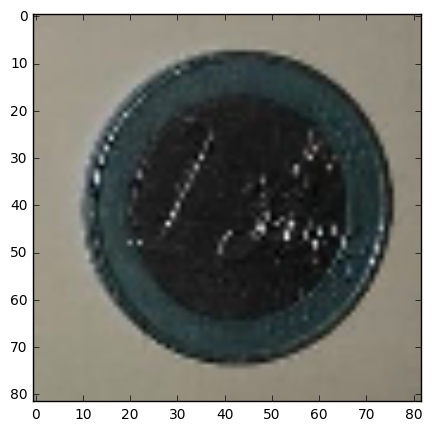

This is 50, 20 or 10 cent


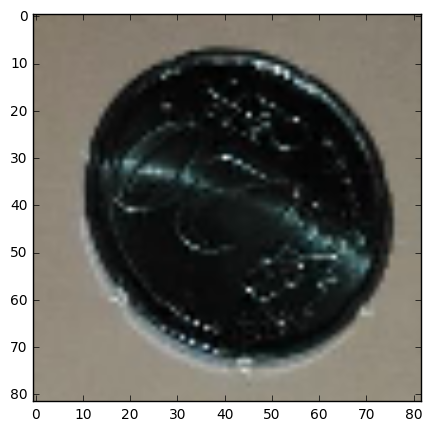

This is 50, 20 or 10 cent


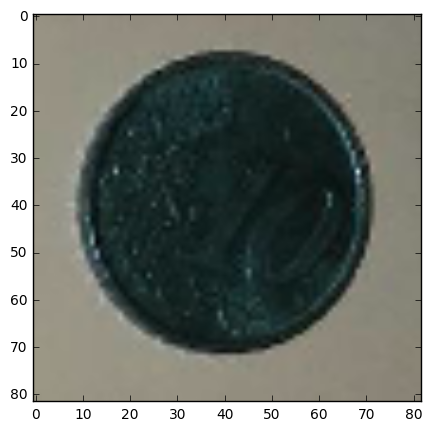

In [4]:
#Print some coins
import matplotlib.pyplot as plt
def printSomeCoints(img, labels, ncoins):
    for i in range(0,ncoins):
        if labels[i] == 0.:
            print "This is 1 euro or 2 euro"
        if labels[i] == 1.:
            print "This is 50, 20 or 10 cent"
        if labels[i] == 2.:
            print "This is 5, 2, 1 cent"
        plt.figure(figsize=(10,5))
        plt.imshow(train[i])
        plt.show()
    
    
printSomeCoints(train, labels_train_nocategorical, 3)

<html>
<body>
<h2 style = "color:red"> Building the classificator (work in progress..): </h2>
<p> Use the training dataset to build the classificator using a ConvNN.</p>
</body>
</html>

In [5]:
#Loading keras deep learnig libraries to build the model: https://keras.io/ 
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Convolution2D, MaxPooling2D
from keras.models import Model, model_from_json
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import initializations

In [9]:
#Model hyperparameters
batch_size = 50 # in each iteration, we consider batch_size training examples at once
num_epochs = 5 # we iterate num_epochs times over the entire training set
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
conv_depth_3 = 128 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with this probability 
drop_prob_2 = 0.5 # dropout in the FC layer with this probability 
hidden_size = 256 # the FC layer will this neurons
data_augmentation = False # Whether to use or not data augmentation

ROWS = 82
COLS = 82
CHANNELS = 3

NN = False
ConvNN = True
if ConvNN == True:
    #Architecture
    inp = Input(shape=(ROWS, COLS, CHANNELS)) # N.B. depth goes first in Keras!
    conv_1 = Convolution2D(conv_depth_1, kernel_size, kernel_size, border_mode='same', activation='relu')(inp)
    pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_1)
    conv_2 = Convolution2D(conv_depth_2, kernel_size, kernel_size, border_mode='same', activation='relu')(pool_1)
    pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
    conv_3 = Convolution2D(conv_depth_3, kernel_size, kernel_size, border_mode='same', activation='relu')(pool_2)
                       

    flat = Flatten()(conv_3)
    hidden = Dense(hidden_size, activation='relu')(flat)
    out = Dense(nb_classes, activation='sigmoid')(hidden)
    model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

if NN == True:
    #Architecture
    inp = Input(shape=(ROWS, COLS, CHANNELS)) # N.B. depth goes first in Keras!                  
    flat = Flatten()(inp)
    hidden = Dense(hidden_size, activation='relu')(flat)
    out = Dense(nb_classes, activation='sigmoid')(hidden)
    model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

    
#print the summary of the architecture
model.summary()

#Visulize the model if desired
#from keras.utils.visualize_util import plot
#plot(model, to_file='Example_of_CNN_CatsVsDogs.pdf')

# reduce the learning rate by factor of 0.5 if the validation loss does not get lower in 7 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=0.0000001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')


# Let's train the model using SGD
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['accuracy'])

# Let's train the SGD model WITHOUT using data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(train, labels_train, batch_size=batch_size, nb_epoch=num_epochs, validation_data=(validation, labels_validation), shuffle=True, callbacks=[reduce_lr])
                       
                       

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 82, 82, 3)     0                                            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 82, 82, 32)    896         input_4[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_5 (MaxPooling2D)    (None, 41, 41, 32)    0           convolution2d_7[0][0]            
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 41, 41, 64)    18496       maxpooling2d_5[0][0]             
___________________________________________________________________________________________